In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from bmis_emg_utils import * 

In [2]:
subjects = 6
data, label = get_emg_data(subjects)
print('The total data shape is {} and label is {}'.format(data.shape, label.shape))

The total data shape is (8, 398684) and label is (398684, 1)


In [3]:
data = standardize_data(data, axis=1)

In [4]:
X, y = window_with_overlap(data, label, window_time=200, overlap=70)
print('The total Input data shape after windowing is {} and label is {}'.format(X.shape, y.shape))

The total Input data shape after windowing is (33221, 8, 40) and label is (33221, 1)


In [5]:
XX_train, yy_train, XX_test, yy_test = spilt_data(X, y, ratio=0.1)
print('Training Set is{} Test Set {}'.format(XX_train.shape, XX_test.shape))

Training Set is(29898, 8, 40) Test Set (3323, 8, 40)


In [6]:
# Expanding the input feature shape

XX_train = np.expand_dims(XX_train, axis=3)
XX_test = np.expand_dims(XX_test, axis=3)
print('Expanded Dimension are {}'.format(XX_train.shape))
input_size = XX_train.shape[1:]
print(input_size)

Expanded Dimension are (29898, 8, 40, 1)
(8, 40, 1)


In [7]:
inputs = tf.keras.Input(shape=input_size)
x = tf.keras.layers.Conv2D(6, 3, activation="relu", input_shape=input_size)(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(151, activation='relu')(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="sEMG-classfier")
model.summary()

Model: "sEMG-classfier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 40, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 38, 6)          60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 36, 32)         1760      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 18, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 18, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 151)            

In [8]:
lr = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-07, clipnorm=1)
ls = 'sparse_categorical_crossentropy'
mtr = 'accuracy'
n_batches = 15
n_epochs = 10
model.compile(optimizer=opt, loss=ls, metrics=mtr)

In [9]:
history = model.fit(XX_train, yy_train, validation_data=(XX_test, yy_test), batch_size=n_batches, epochs= n_epochs)

Epoch 1/10
1994/1994 [==============================] - 12s 5ms/step - loss: 1.2087 - accuracy: 0.5126 - val_loss: 0.8178 - val_accuracy: 0.6930
Epoch 2/10
1994/1994 [==============================] - 11s 5ms/step - loss: 0.7368 - accuracy: 0.7175 - val_loss: 0.5746 - val_accuracy: 0.7812
Epoch 3/10
1994/1994 [==============================] - 10s 5ms/step - loss: 0.5795 - accuracy: 0.7814 - val_loss: 0.4462 - val_accuracy: 0.8372
Epoch 4/10
1994/1994 [==============================] - 11s 5ms/step - loss: 0.4925 - accuracy: 0.8166 - val_loss: 0.4058 - val_accuracy: 0.8534
Epoch 5/10
1994/1994 [==============================] - 11s 5ms/step - loss: 0.4435 - accuracy: 0.8391 - val_loss: 0.3621 - val_accuracy: 0.8733
Epoch 6/10
1994/1994 [==============================] - 11s 5ms/step - loss: 0.4062 - accuracy: 0.8562 - val_loss: 0.3642 - val_accuracy: 0.8724
Epoch 7/10
1994/1994 [==============================] - 11s 5ms/step - loss: 0.3770 - accuracy: 0.8646 - val_loss: 0.3163 - val_ac

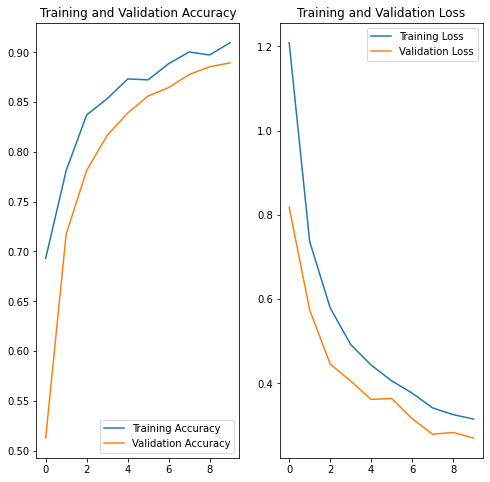

In [10]:
validation_loss = history.history['val_loss']
training_loss = history.history['loss']

validation_accuracy = history.history['val_accuracy']
training_accuracy = history.history['accuracy']

epoch_range = range(n_epochs)
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, training_accuracby, label = "Training Accuracy")
plt.plot(epoch_range, validation_accuracy, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epoch_range, training_loss, label = "Training Loss")
plt.plot(epoch_range, validation_loss, label = "Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()